# Import Dependencies

In [1]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
# from torchvision.datasets import MNIST
from torchvision.utils import save_image


In [2]:
# %matplotlib inline
# %matplotlib notebook
import tqdm, copy
import random, os
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from collections import defaultdict
from overcooked_ai_py.utils import save_pickle
from human_aware_rl.utils import set_global_seed
from human_aware_rl.human.process_dataframes import *
from human_aware_rl.static import *
import pickle as pkl

set_global_seed(1884)
import ast
import json

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import os
from ast import literal_eval
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [3]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression


# Helper Functions

In [4]:
def json_eval(s):
    json_acceptable_string = s.replace("'", "\"")
    d = json.loads(json_acceptable_string)
    return d

In [5]:

def f_p1(t, a, p1_data):
    t_partial = t[int(a)-1:int(a)]
#     print('t_input', t)
    return [p1_data[int(j)]['position'][0] for j in t_partial], [p1_data[int(j)]['position'][1] for j in t_partial]
def f_p2(t, a, p2_data):
    t_partial = t[int(a)-1:int(a)]
    return [p2_data[int(j)]['position'][0] for j in t_partial], [p2_data[int(j)]['position'][1] for j in t_partial]



def arrow_p1(t, a, p1_data):
#     t_partial = t[int(a)-1:int(a)+1]
#     print('t_input', t)
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1],\
            p1_data[int(a)]['orientation'][0], p1_data[int(a)]['orientation'][1]
def arrow_p2(t, a, p2_data):
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1],\
            p2_data[int(a)]['orientation'][0], p2_data[int(a)]['orientation'][1]


def held_p1(t, a, p1_data):
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1],\
            p1_data[int(a)]['orientation'][0], p1_data[int(a)]['orientation'][1]
def held_p2(t, a, p2_data):
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1],\
            p2_data[int(a)]['orientation'][0], p2_data[int(a)]['orientation'][1]


def world_obj(t, a, objects_data):
    obj_world = objects_data[int(a)]
    if len(obj_world)==0:
        return []
    objects_list = []
    for i in range(len(obj_world)):
        obj = obj_world[i]
        name = obj_world[i]['name']
        position = obj_world[i]['position']
        if name == 'onion':
            color = 'y'
            objects_list.append((position[0], position[1], name, color))
        if name == 'dish':
            color = 'k'
            objects_list.append((position[0], position[1], name, color))
        if name == 'soup':
            if obj['is_cooking'] is True:
                color = 'r'
            elif obj['is_ready'] is True:
                color = 'g'
            else:
                color = 'orange'
            objects_list.append((position[0], position[1], name, color))
        
    return objects_list


def obj_p1(t, a, p1_data):
#     t_partial = t[int(a)-1:int(a)+1]
#     print('t_input', t)
    color = 'k'
    if p1_data[int(a)]['held_object'] is None:
        return [None, None, None, None]
    else:
        name = p1_data[int(a)]['held_object']['name']
        if name == 'dish':
            color = 'k'
        elif name == 'onion':
            color = 'y'
#         elif name == 'onion':
#             color = 'y'
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1], p1_data[int(a)]['held_object']['name'], color

def obj_p2(t, a, p2_data):
    color = 'k'
    if p2_data[int(a)]['held_object'] is None:
        return [None, None, None, None]
    else:
        name = p2_data[int(a)]['held_object']['name']
        if name == 'dish':
            color = 'k'
        elif name == 'onion':
            color = 'y'
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1], p2_data[int(a)]['held_object']['name'], color


# [{'name': 'soup',
#    'position': [4, 1],
#    '_ingredients': [{'name': 'onion', 'position': [4, 1]},
#     {'name': 'onion', 'position': [4, 1]}],
#    'cooking_tick': -1,
#    'is_cooking': False,
#    'is_ready': False,
#    'is_idle': True,
#    'cook_time': -1,
#    '_cooking_tick': -1}],

NORTH = (0, -1)
SOUTH = (0, 1)
EAST  = (1, 0)
WEST  = (-1, 0)
STAY = (0,0)
INTERACT = 'INTERACT'
# STAY = [0,0]

def action_p1(t, a, p1_data):
    if p1_data[int(a)] == 'INTERACT':
        act = 'I'
    else:
        x, y = p1_data[int(a)][0], p1_data[int(a)][1]
        act = 'N'
        if (x,y) == NORTH:
            act = 'N'
        if (x,y) == SOUTH:
            act = 'S'
        if (x,y) == EAST:
            act = 'E'
        if (x,y) == WEST:
            act = 'W'
        if (x,y) == STAY:
            act = 'Y'
        
    return act

def action_p2(t, a, p2_data):
    if p2_data[int(a)] == 'INTERACT':
        act = 'I'
    else:
        x, y = p2_data[int(a)][0], p2_data[int(a)][1]
        act = 'N'
        if (x,y) == NORTH:
            act = 'N'
        if (x,y) == SOUTH:
            act = 'S'
        if (x,y) == EAST:
            act = 'E'
        if (x,y) == WEST:
            act = 'W'
        if (x,y) == STAY:
            act = 'Y'
        
    return act





In [6]:
def import_2019_data():
    hh_all_2019_file = '/Users/michellezhao/Documents/overcooked_research/human_aware_rl/human_aware_rl/static/human_data/cleaned/2019_hh_trials_all.pickle'

    with open(hh_all_2019_file,'rb') as file:
        humans_2019_file = pkl.load(file)

    humans_2019_file.to_csv('humans_all_2019.csv')
    old_trials = humans_2019_file
    return old_trials

def import_2020_data():
    hh_all_2020_file = '/Users/michellezhao/Documents/overcooked_research/human_aware_rl/human_aware_rl/static/human_data/cleaned/2020_hh_trials_all.pickle'

    with open(hh_all_2020_file,'rb') as file:
        humans_2020_file = pkl.load(file)

    humans_2020_file.to_csv('humans_all_2020.csv')
    new_trials = humans_2020_file
    return new_trials






### What are the features of each order?

1. Other pot was cooking while order was served (0 or 1)
2. Other pot was done while order was served (0 or 1)
3. Number of onions in other pot while order was served (0 or 1)
4. Mean number of steps P1 took while transporting onions
5. Mean number of steps P2 took while transporting onions
6. Mean number of object passes
7. How often each counter was used 
8. Both idle time
9. Both moving time
10. P1 idle while P2 moving
11. P2 idle while P1 moving




# Define Feature Extraction Functions

In [7]:
def compute_steps_per_object_transfer(p1_data, p2_data, objects_data, p1_actions, 
                                      p2_actions, name, time_elapsed):

    N_steps = len(p1_data)
    a_min = 1    # the minimial value of the paramater a
    a_max = N_steps-1   # the maximal value of the paramater a
    a_init = 1   # the value of the parameter a to be used initially, when the graph is created

    t = np.linspace(0, N_steps-1, N_steps)
    
    counter_location_to_id = {
        (2,1): 1,
        (2,2): 2, 
        (2,3): 3,
        (1,0): 4,
        (1,4): 5,
        (4,2): 6,
        (4,3): 7
    }



    obj_count_id = 0
    next_obj_count_id = 0

    object_list_tracker = {}
    object_location_tracker = {}

    ordered_delivered_tracker = {}
    top_soup_counter_id = 0 # (3,0)
    right_soup_counter_id = 0 # (4,1) 
    top_soup_contents_dict = {'this_contents':[], 'other_contents':[], 'other_state':'empty'} # (3,0)
    right_soup_contents_dict = {'this_contents':[], 'other_contents':[], 'other_state':'empty'} # (4,1) 
    # states: empty, cooking, cooked, partial

    p2_carrying_soup = None
    p2_carrying_soup_pot_side = None
    p2_carrying_soup_pot_side_id = None
    absolute_order_counter = 0
    p2_time_picked_up_soup = None
    p2_time_delivered_soup = None

    players_holding = {1: None, 2: None}

    layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
    layout = np.array([list(elem) for elem in layout])
    grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))

    # loop over your images
    for a in range(len(t)-1):
    # for a in range(100):

        p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
        p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
        p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                    obj_p1(t, a, p1_data)[1], \
                    obj_p1(t, a, p1_data)[2]
        p1_act = action_p1(t, a, p1_actions)

        p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
        p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
        p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                    obj_p2(t, a, p2_data)[1], \
                    obj_p2(t, a, p2_data)[2]
        p2_act = action_p2(t, a, p2_actions)
        objects_list = world_obj(t, a, objects_data)
        t1 = time_elapsed[a]

        # cook_state 
        # 0 = uncooked
        # 1 = cooking
        # 2 = cooked

        b = a+1
        p1_x_next, p1_y_next = f_p1(t, b, p1_data)[0], f_p1(t, b, p1_data)[1]
        p1_dir_x_next, p1_dir_y_next = arrow_p1(t, b, p1_data)[2], arrow_p1(t, b, p1_data)[3]
        p1_obj_x_next, p1_obj_y_next, p1_obj_name_next = obj_p1(t, b, p1_data)[0], \
                    obj_p1(t, b, p1_data)[1], \
                    obj_p1(t, b, p1_data)[2]
        p1_act_next = action_p1(t, b, p1_actions)

        p2_x_next, p2_y_next = f_p2(t, b, p2_data)[0], f_p2(t, b, p2_data)[1]
        p2_dir_x_next, p2_dir_y_next = arrow_p2(t, b, p2_data)[2], arrow_p2(t, b, p2_data)[3]
        p2_obj_x_next, p2_obj_y_next, p2_obj_name_next = obj_p2(t, b, p2_data)[0], \
                    obj_p2(t, b, p2_data)[1], \
                    obj_p2(t, b, p2_data)[2]
        p2_act_next = action_p2(t, a, p2_actions)
        objects_list_next = world_obj(t, b, objects_data)
        t2 = time_elapsed[b]


        ################## PLAYER 1'S MOVEMENT ##################
        # If P1 moves or stays
        if p1_act in ['N', 'S', 'E', 'W']:
    #         print(p1_act, (p1_dir_x_next, p1_dir_y_next))

            # If P1 is carrying something and moving (dish or onion)
            if players_holding[1] is not None:
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_held_id = players_holding[1]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['n_actions_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location
                object_list_tracker[object_held_id]['p1_n_actions_since_pickup'] += 1

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id


        # If P1 interacted
        if p1_act == 'I':
            # If P1 picked up an object
            if p1_obj_x is None and p1_obj_x_next is not None:
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_location_tracker[obj_location] = obj_count_id

                if obj_count_id not in object_list_tracker:
                    object_list_tracker[obj_count_id] = {}
                object_list_tracker[obj_count_id]['name'] = p1_obj_name_next
                object_list_tracker[obj_count_id]['player_holding'] = 1
                object_list_tracker[obj_count_id]['id'] = obj_count_id
                object_list_tracker[obj_count_id]['n_actions_since_pickup'] = 0
                object_list_tracker[obj_count_id]['location'] = obj_location
                object_list_tracker[obj_count_id]['on_screen'] = True
                object_list_tracker[obj_count_id]['player_holding_list'] = [1]
                object_list_tracker[obj_count_id]['p1_n_actions_since_pickup'] = 1
                object_list_tracker[obj_count_id]['p2_n_actions_since_pickup'] = 0
                object_list_tracker[obj_count_id]['counter_used'] = []
                object_list_tracker[obj_count_id]['p1_time_started'] = t1
                object_list_tracker[obj_count_id]['p1_time_completed'] = None
                object_list_tracker[obj_count_id]['p2_time_started'] = None
                object_list_tracker[obj_count_id]['p2_time_completed'] = None



                players_holding[1] = obj_count_id

                obj_count_id += 1

            # If P1 put down an object
            if p1_obj_x is not None and p1_obj_x_next is None:
                object_held_id = players_holding[1]

                object_list_tracker[object_held_id]['player_holding'] = 0
                object_list_tracker[object_held_id]['n_actions_since_pickup'] += 1
                object_list_tracker[object_held_id]['player_holding_list'].append(0)
                object_list_tracker[object_held_id]['p1_n_actions_since_pickup'] += 1


                placed_obj_x, placed_obj_y = list(p1_x_next)[0]+p1_dir_x_next, list(p1_y_next)[0]+p1_dir_y_next
                old_obj_location = object_list_tracker[object_held_id]['location']
                new_obj_location = (placed_obj_x, placed_obj_y)
                object_list_tracker[object_held_id]['location'] = new_obj_location

                object_location_tracker.pop(old_obj_location, None)
                object_location_tracker[new_obj_location] = object_held_id

                counter_index = counter_location_to_id[(placed_obj_x, placed_obj_y)]
                object_list_tracker[object_held_id]['counter_used'].append(counter_index)

                object_list_tracker[object_held_id]['p1_time_completed'] = t2

                players_holding[1] = None


        ################## PLAYER 2'S MOVEMENT ##################
        # If P2 moves or stays
        if p2_act in ['N', 'S', 'E', 'W']:

            # If P2 is moving with an object: onion, dish, or soup
            if players_holding[2] is not None:
                obj_location = (p2_obj_x_next, p2_obj_y_next)
                object_held_id = players_holding[2]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['n_actions_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location
                object_list_tracker[object_held_id]['p2_n_actions_since_pickup'] += 1

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id


        # If P2 interacted
        if p2_act == 'I':
            placed_x, placed_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next
            # If P2 picked up soup from the pot. P2 would be carrying a dish
            if p2_obj_name_next == 'soup':

                # P2 was already carrying this soup
#                 if p2_obj_name == 'soup':
#                     print('WHAT IS GOING ON', (p2_data[a], p2_actions[a]))
#                     print('WHAT IS GOING ON NEXT', (p2_data[b], p2_actions[b]))
#                     print('picked up from', (placed_x, placed_y))
#                     print()

                # P2 filled up a dish with the soup
                if p2_obj_name == 'dish':
                    objects_status = objects_data[a]
                    objects_status_next = objects_data[b]
                    top_pot_status = 'empty'
                    right_pot_status = 'empty'
                    for obj_status in objects_status:
                        if obj_status['name'] == 'soup' and obj_status['position'] == [3,0]:
                            if obj_status['is_cooking'] == True:
                                top_pot_status = 'cooking'
                            if obj_status['is_ready'] == True:
                                top_pot_status = 'ready'
                            if obj_status['is_idle'] == True:
                                top_pot_status = 'idle'
                        if obj_status['name'] == 'soup' and obj_status['position'] == [4,1]:
                            if obj_status['is_cooking'] == True:
                                right_pot_status = 'cooking'
                            if obj_status['is_ready'] == True:
                                right_pot_status = 'ready'
                            if obj_status['is_idle'] == True:
                                right_pot_status = 'idle'

                    top_soup_contents_dict['other_state'] = right_pot_status
                    right_soup_contents_dict['other_state'] = top_pot_status

                    p2_time_picked_up_soup = t1

                    # picked up from top counter
                    if (placed_x, placed_y) == (3,0):
                        p2_carrying_soup = copy.deepcopy(top_soup_contents_dict)
                        p2_carrying_soup_pot_side = 'top'
                        p2_carrying_soup_pot_side_id = top_soup_counter_id

                        top_soup_contents_dict['this_contents'] = [] # (3,0)
                        right_soup_contents_dict['other_contents'] = []
                        right_soup_contents_dict['other_state'] = 'empty'
                        top_soup_counter_id += 1

    #                     objects_data_next [{'name': 'soup', 'position': [3, 0], '_ingredients': [{'name': 'onion', 'position': [3, 0]}], 'cooking_tick': -1, 'is_cooking': False, 'is_ready': False, 'is_idle': True, 'cook_time': -1, '_cooking_tick': -1}]

                    # picked up from right counter
                    if (placed_x, placed_y) == (4,1):
                        p2_carrying_soup = copy.deepcopy(right_soup_contents_dict)
                        p2_carrying_soup_pot_side = 'right'
                        p2_carrying_soup_pot_side_id = right_soup_counter_id

                        right_soup_contents_dict['this_contents'] = [] # (4,1) 
                        top_soup_contents_dict['other_contents'] = []
                        top_soup_contents_dict['other_state'] = 'empty'
                        right_soup_counter_id += 1


            # If P2 picked up an object
            if p2_obj_x is None and p2_obj_x_next is not None:
                placed_x, placed_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next


                if (placed_x, placed_y) in object_location_tracker:
                    obj_picked_id = object_location_tracker[(placed_x, placed_y)]
                else:
                    print('!!! problem p2 pickup not found')
                    nearest_key = min(list(object_location_tracker.keys()), key=lambda c: (c[0]- placed_x)**2 + (c[1]-placed_y)**2)
                    obj_picked_id = object_location_tracker[nearest_key]


                new_obj_location = (p2_obj_x_next, p2_obj_y_next)


                object_list_tracker[obj_picked_id]['player_holding'] = 2
                object_list_tracker[obj_picked_id]['n_actions_since_pickup'] += 1
                object_list_tracker[obj_picked_id]['location'] = new_obj_location
                object_list_tracker[obj_picked_id]['on_screen'] = True
                object_list_tracker[obj_picked_id]['player_holding_list'].append(2)
                object_list_tracker[obj_picked_id]['p2_n_actions_since_pickup'] += 1
                object_list_tracker[obj_picked_id]['p2_time_started'] = t1

                players_holding[2] = obj_picked_id

                object_location_tracker.pop((placed_x, placed_y), None)
                object_location_tracker[new_obj_location] = obj_picked_id


        # If P2 put down an object
        if p2_obj_x is not None and p2_obj_x_next is None:
            object_held_id = players_holding[2]
            placed_obj_x, placed_obj_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next

            # If P2 delivered a soup
            if p2_obj_name == 'soup' and (placed_obj_x, placed_obj_y)==(3,4):
                p2_time_delivered_soup = t2
                ordered_delivered_tracker[absolute_order_counter] = {}
                ordered_delivered_tracker[absolute_order_counter]['details'] = p2_carrying_soup
                ordered_delivered_tracker[absolute_order_counter]['pot_side'] = p2_carrying_soup_pot_side
                ordered_delivered_tracker[absolute_order_counter]['pot_side_id'] = p2_carrying_soup_pot_side_id
                ordered_delivered_tracker[absolute_order_counter]['time_picked_up'] = p2_time_picked_up_soup
                ordered_delivered_tracker[absolute_order_counter]['time_delivered'] = p2_time_delivered_soup

                absolute_order_counter += 1




            else:
                # placed at top counter pot 
                if (placed_obj_x, placed_obj_y) == (3,0):
                    top_soup_contents_dict['this_contents'].append(object_held_id)
                    right_soup_contents_dict['other_contents'].append(object_held_id)

                # placed at right counter pot
                if (placed_obj_x, placed_obj_y) == (4,1):
                    right_soup_contents_dict['this_contents'].append(object_held_id)
                    top_soup_contents_dict['other_contents'].append(object_held_id)


                object_list_tracker[object_held_id]['player_holding'] = 0
                object_list_tracker[object_held_id]['n_actions_since_pickup'] += 1
                object_list_tracker[object_held_id]['player_holding_list'].append(0)
                object_list_tracker[object_held_id]['p2_n_actions_since_pickup'] += 1


                placed_obj_x, placed_obj_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next
                old_obj_location = object_list_tracker[object_held_id]['location']
                new_obj_location = (placed_obj_x, placed_obj_y)
                object_list_tracker[object_held_id]['location'] = new_obj_location

                object_location_tracker.pop(old_obj_location, None)
                object_location_tracker[new_obj_location] = object_held_id

                if (placed_obj_x, placed_obj_y) in counter_location_to_id:
                    counter_index = counter_location_to_id[(placed_obj_x, placed_obj_y)]
                    object_list_tracker[object_held_id]['counter_used'].append(counter_index)

                object_list_tracker[object_held_id]['p2_time_completed'] = t2

            players_holding[2] = None

    return object_list_tracker, ordered_delivered_tracker


In [8]:

def pull_features_from_output(object_list_tracker, ordered_delivered_tracker):
    other_pot_contains_num_onions = []
    other_pot_states = []
    steps_p1_took_total_order = []
    steps_p2_took_total_order = []
    order_completion_times = []
    for order_id in ordered_delivered_tracker:
        n_other = len(ordered_delivered_tracker[order_id]['details']['other_contents'])
        other_pot_contains_num_onions.append(n_other)

        state_other = ordered_delivered_tracker[order_id]['details']['other_state']
        other_pot_states.append(state_other)
        
        onion_indices = ordered_delivered_tracker[order_id]['details']['this_contents']
        steps_p1_took = 0
        steps_p2_took = 0
        for onion_idx in onion_indices:
            steps_p1_took += object_list_tracker[onion_idx]['p1_n_actions_since_pickup']
            steps_p2_took += object_list_tracker[onion_idx]['p2_n_actions_since_pickup']
        steps_p1_took_total_order.append(steps_p1_took)
        steps_p2_took_total_order.append(steps_p2_took)
        
        order_start_time = object_list_tracker[onion_idx]['p1_time_started']
        order_end_time = ordered_delivered_tracker[order_id]['time_delivered']
        time_to_complete = order_end_time - order_start_time
        order_completion_times.append(time_to_complete)
        
    return other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, steps_p2_took_total_order, order_completion_times
        
    

In [9]:
def plot_results(other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, steps_p2_took_total_order, order_completion_times):
    plt.scatter(range(len(other_pot_contains_num_onions)), other_pot_contains_num_onions)
    plt.plot(range(len(other_pot_contains_num_onions)), other_pot_contains_num_onions)
    plt.xlabel('Order Number')
    plt.ylabel("Number of Onions in Other Pot")
    plt.title("Number of Onions in Other Pot vs. Order Number")
    plt.show()
    plt.close()

    plt.scatter(range(len(other_pot_states)), other_pot_states)
    plt.plot(range(len(other_pot_states)), other_pot_states)
    plt.xlabel('Order Number')
    plt.ylabel("Other Pot State")
    plt.title("Other Pot State vs. Order Number")
    plt.show()
    plt.close()
    
    plt.scatter(range(len(steps_p1_took_total_order)), steps_p1_took_total_order)
    plt.scatter(range(len(steps_p2_took_total_order)), steps_p2_took_total_order)
    plt.xlabel('Order Number')
    plt.ylabel("N Steps Players Took")
    plt.title("Player Steps vs. Order Number")
    plt.legend(['P1', 'P2'])
    plt.plot(range(len(steps_p1_took_total_order)), steps_p1_took_total_order)
    plt.plot(range(len(steps_p2_took_total_order)), steps_p2_took_total_order)
    plt.show()
    plt.close()
    
    plt.scatter(range(len(order_completion_times)), order_completion_times)
    plt.plot(range(len(order_completion_times)), order_completion_times)
    plt.xlabel('Order Number')
    plt.ylabel("Order Completion Time")
    plt.title("Completion Time vs. Order Number")
    plt.show()
    plt.close()
    
    

# Run Feature Extraction

trial_id 9


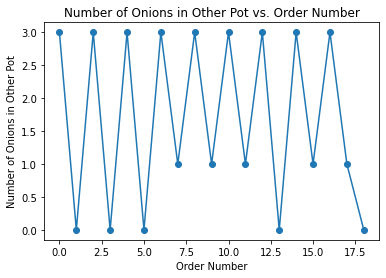

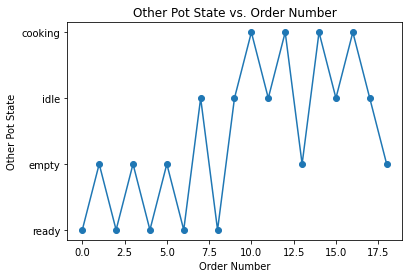

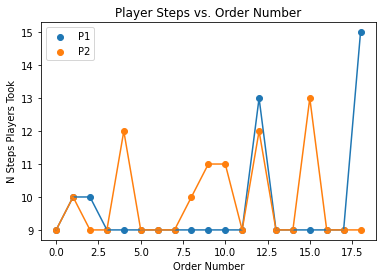

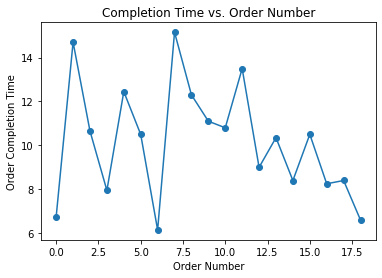


trial_id 14


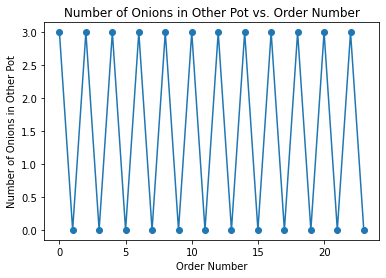

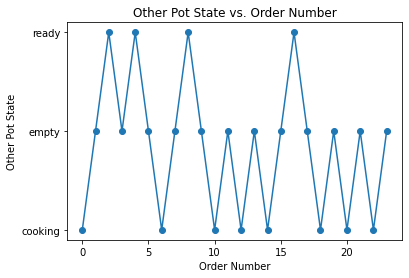

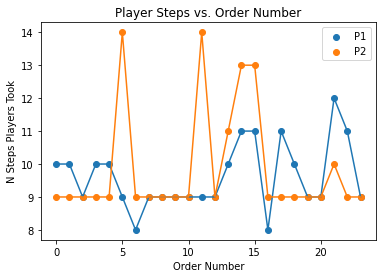

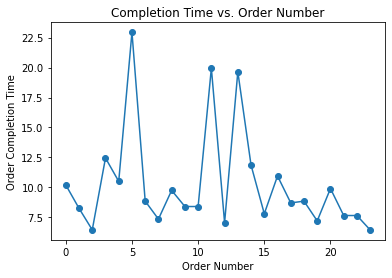


trial_id 19


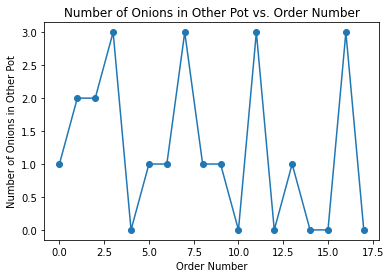

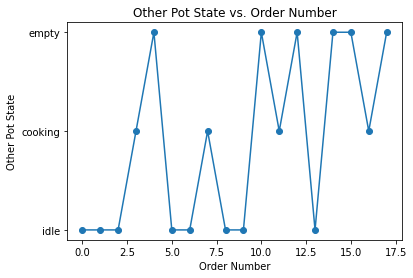

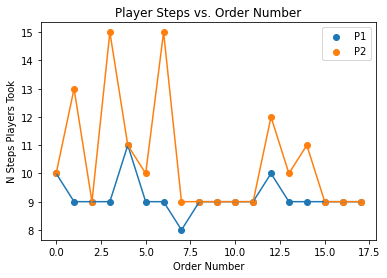

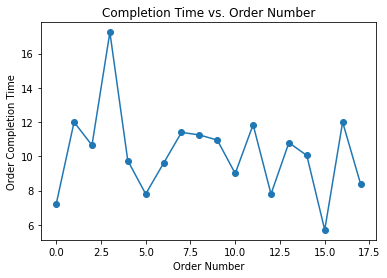


trial_id 24


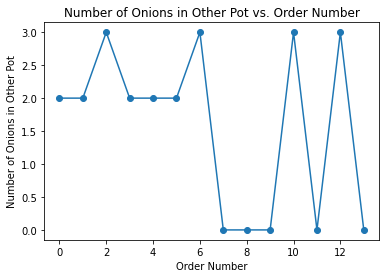

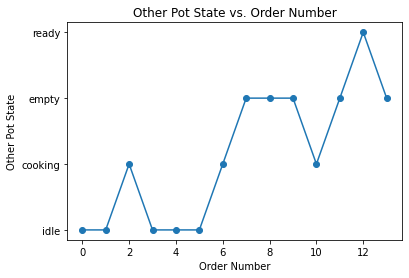

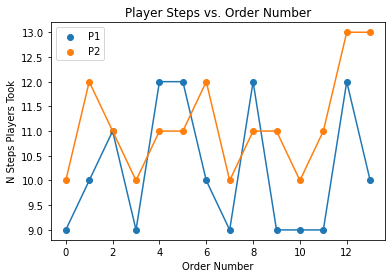

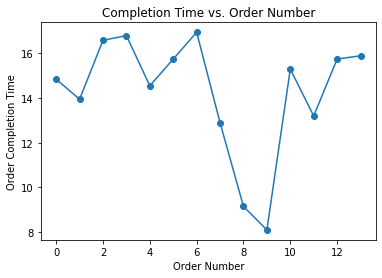


trial_id 54


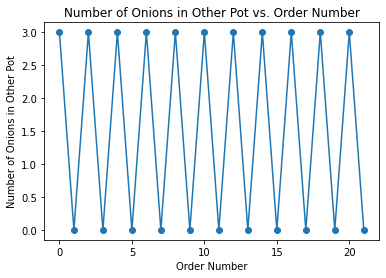

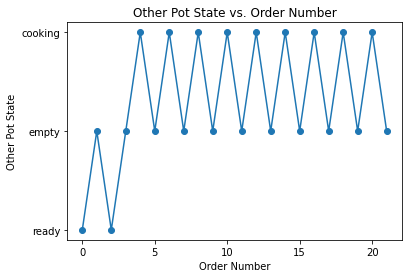

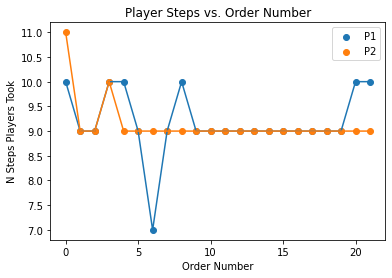

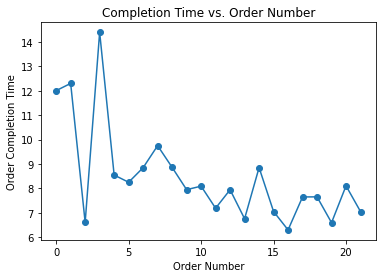


trial_id 59
!!! problem p2 pickup not found
!!! problem p2 pickup not found


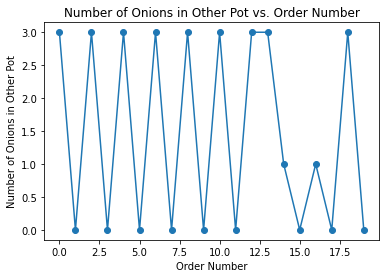

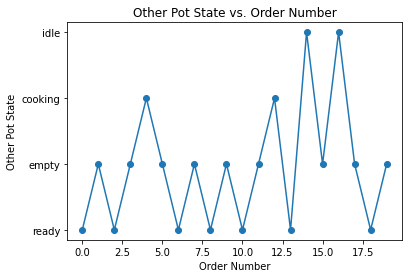

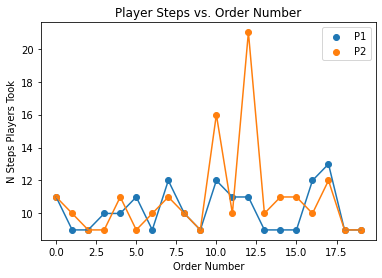

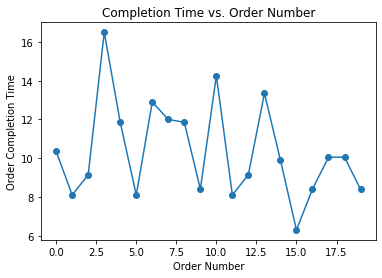


trial_id 64


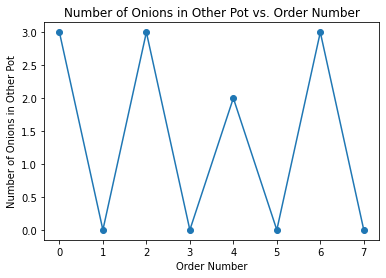

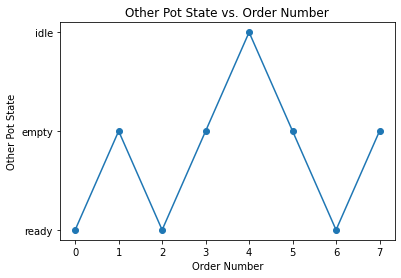

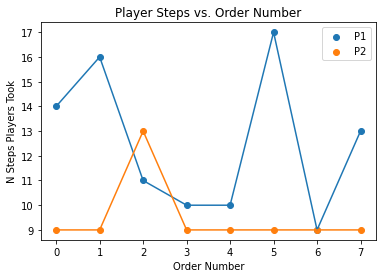

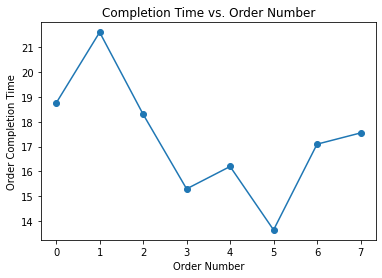


trial_id 69


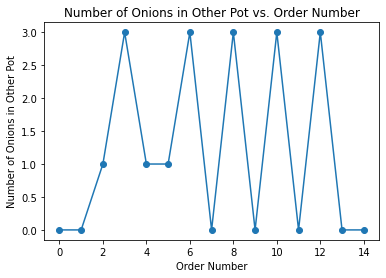

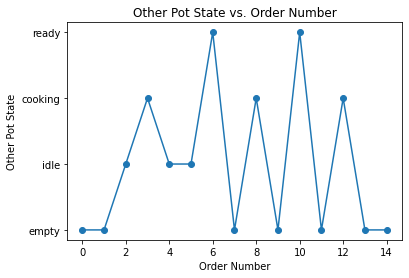

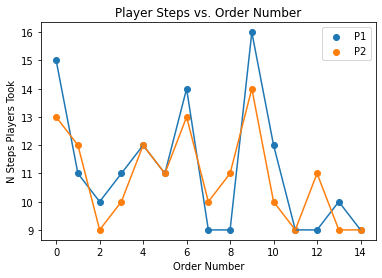

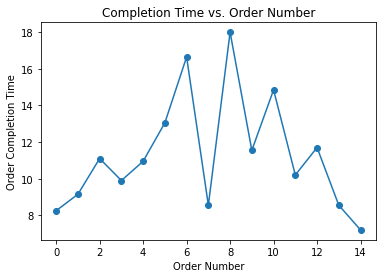


trial_id 79


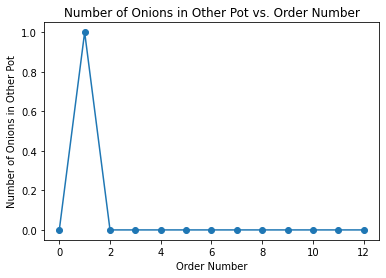

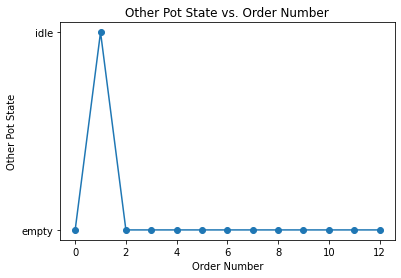

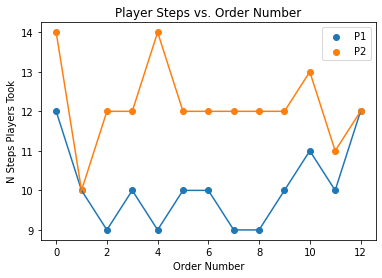

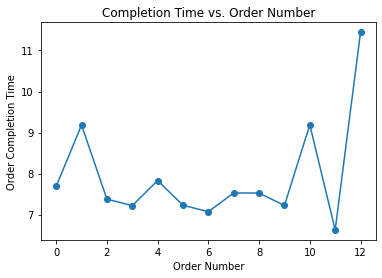


trial_id 89


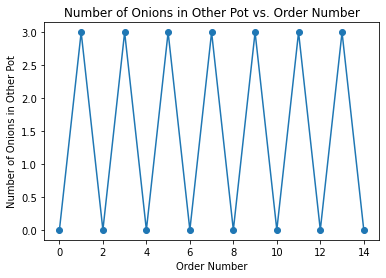

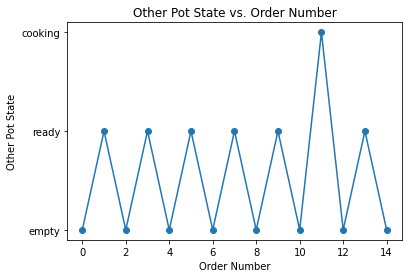

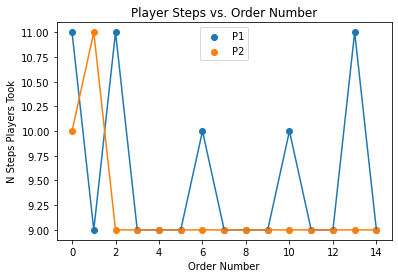

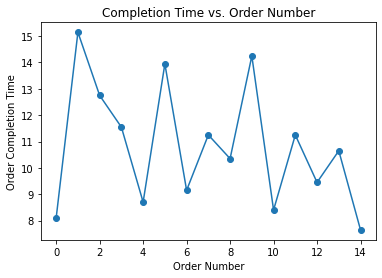


trial_id 99


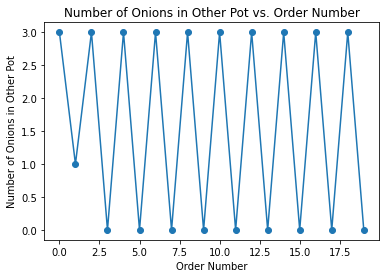

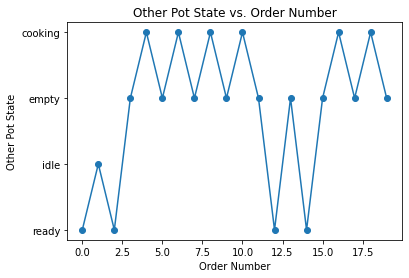

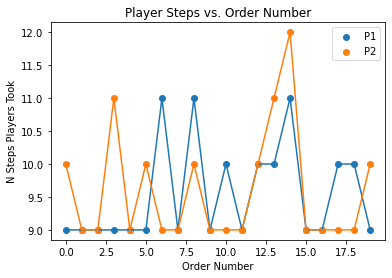

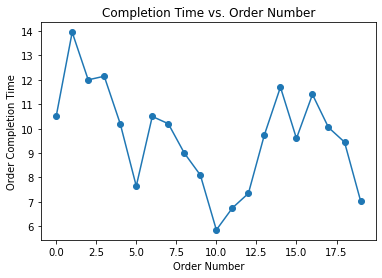


trial_id 114


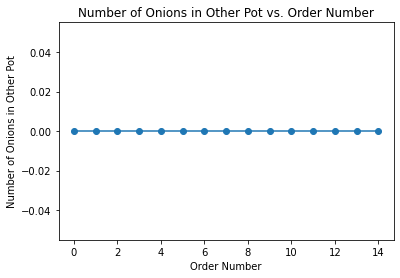

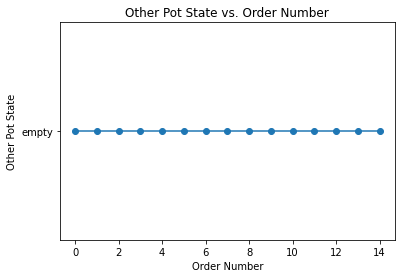

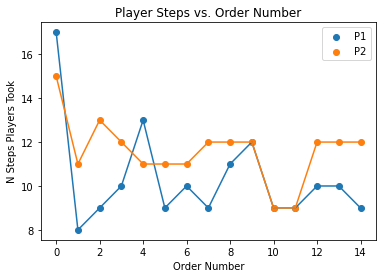

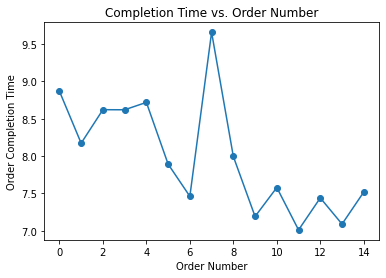

In [10]:

name = 'random0'
title = 'Forced Coord'

# name = 'random0'
# title = 'Forced Coordination'
old_trials = import_2019_data()
layout_trials = old_trials[old_trials['layout_name']==name]['trial_id'].unique()
# name = 'random0'
# title = 'Forced Coordination'
trial_data = {}

for j in range(len(layout_trials)):
# for j in [5]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    time_elapsed = trial_df['time_elapsed'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
        p1_index = 1
        p2_index = 0

        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
        
    object_list_tracker, ordered_delivered_tracker = compute_steps_per_object_transfer(p1_data, p2_data, objects_data, p1_actions, 
                                      p2_actions, name, time_elapsed)
    
    other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, \
        steps_p2_took_total_order, order_completion_times = pull_features_from_output(object_list_tracker, ordered_delivered_tracker)
        
    plot_results(other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, steps_p2_took_total_order, order_completion_times)
    print()


# For every order by every team, extract features. Then, cluster order features.

In [11]:

name = 'random0'
title = 'Forced Coord'

# name = 'random0'
# title = 'Forced Coordination'
old_trials = import_2019_data()
layout_trials = old_trials[old_trials['layout_name']==name]['trial_id'].unique()
# name = 'random0'
# title = 'Forced Coordination'
trial_data = {}

orders_features_dict = {
    'other_pot_contains_num_onions':[], 
    'other_pot_states':[], 
    'steps_p1_took_total_order':[],
    'steps_p2_took_total_order':[], 
    'order_completion_times':[]
}

for j in range(len(layout_trials)):
# for j in [5]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    time_elapsed = trial_df['time_elapsed'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
        p1_index = 1
        p2_index = 0

        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
        
    object_list_tracker, ordered_delivered_tracker = compute_steps_per_object_transfer(p1_data, p2_data, objects_data, p1_actions, 
                                      p2_actions, name, time_elapsed)
    
    other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, \
        steps_p2_took_total_order, order_completion_times = pull_features_from_output(object_list_tracker, ordered_delivered_tracker)
        
    orders_features_dict['other_pot_contains_num_onions'].extend(other_pot_contains_num_onions)
    orders_features_dict['other_pot_states'].extend(other_pot_states)
    orders_features_dict['steps_p1_took_total_order'].extend(steps_p1_took_total_order)
    orders_features_dict['steps_p2_took_total_order'].extend(steps_p2_took_total_order)
    orders_features_dict['order_completion_times'].extend(order_completion_times)
    
        
#     plot_results(other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, steps_p2_took_total_order, order_completion_times)
#     print()


trial_id 9
trial_id 14
trial_id 19
trial_id 24
trial_id 54
trial_id 59
!!! problem p2 pickup not found
!!! problem p2 pickup not found
trial_id 64
trial_id 69
trial_id 79
trial_id 89
trial_id 99
trial_id 114


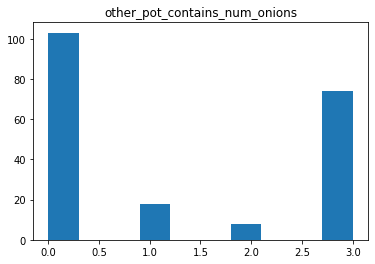

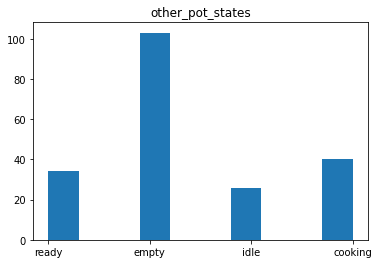

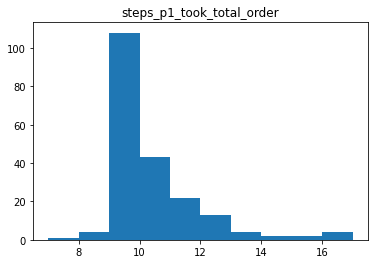

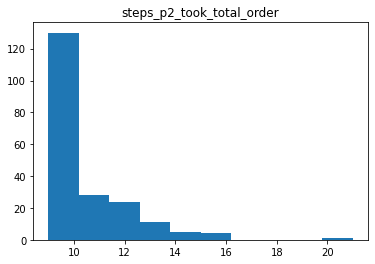

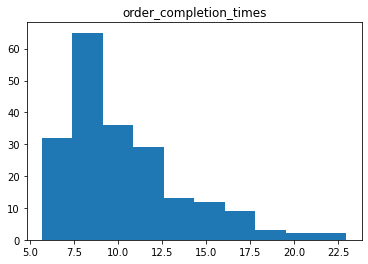

In [12]:
for key_name in orders_features_dict:
    key_data = orders_features_dict[key_name]
    plt.hist(key_data)
    plt.title(key_name)
    plt.show()
    
    

### Perform KMeans Clustering

In [13]:
def generate_data_from_order_features(orders_features_dict):
    X_data = []
    for key_name in orders_features_dict:
        key_data = orders_features_dict[key_name]
        if key_name == 'other_pot_states':
            continue

        X_data.append(key_data)

    X_data= np.array(X_data).T
#     print(X_data.shape)
    return X_data
    

In [14]:
# X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])

X_data = generate_data_from_order_features(orders_features_dict)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_data)



In [15]:

name = 'random0'
title = 'Forced Coord'

# name = 'random0'
# title = 'Forced Coordination'
old_trials = import_2019_data()
layout_trials = old_trials[old_trials['layout_name']==name]['trial_id'].unique()
# name = 'random0'
# title = 'Forced Coordination'
trial_data = {}

team_order_features_dict = {}
team_num_to_score = {}

for j in range(len(layout_trials)):
    orders_features_dict = {
        'other_pot_contains_num_onions':[], 
        'other_pot_states':[], 
        'steps_p1_took_total_order':[],
        'steps_p2_took_total_order':[], 
        'order_completion_times':[]
    }
    trial_id = layout_trials[j]
#     print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    time_elapsed = trial_df['time_elapsed'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
        p1_index = 1
        p2_index = 0

        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
        
    object_list_tracker, ordered_delivered_tracker = compute_steps_per_object_transfer(p1_data, p2_data, objects_data, p1_actions, 
                                      p2_actions, name, time_elapsed)
    
    other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, \
        steps_p2_took_total_order, order_completion_times = pull_features_from_output(object_list_tracker, ordered_delivered_tracker)
        
    orders_features_dict['other_pot_contains_num_onions'].extend(other_pot_contains_num_onions)
    orders_features_dict['other_pot_states'].extend(other_pot_states)
    orders_features_dict['steps_p1_took_total_order'].extend(steps_p1_took_total_order)
    orders_features_dict['steps_p2_took_total_order'].extend(steps_p2_took_total_order)
    orders_features_dict['order_completion_times'].extend(order_completion_times)
    
    team_order_features_dict[trial_id] = orders_features_dict
    team_num_to_score[trial_id] = score
#     plot_results(other_pot_contains_num_onions, other_pot_states, steps_p1_took_total_order, steps_p2_took_total_order, order_completion_times)
#     print()


!!! problem p2 pickup not found
!!! problem p2 pickup not found


In [16]:
team_order_clusters = {}

for team_num in team_order_features_dict:
    orders_features_dict = team_order_features_dict[team_num]
    team_data = generate_data_from_order_features(orders_features_dict)
    kmeans_prediction = kmeans.predict(team_data)
    team_order_clusters[team_num] = kmeans_prediction
    
#     plt.scatter(range(len(kmeans_prediction)), kmeans_prediction)
#     plt.plot(range(len(kmeans_prediction)), kmeans_prediction)
#     plt.title('Team Number: '+str(team_num))
#     plt.show()


# A Naive Way of Identifying Strategy

## If the number of onions in the other pot alternates between 3 and 0, then strategy is 1. Otherwise, the strategy is 2. 


In [17]:
def get_naive_strategy_from_order_features(orders_features_dict):
    strategy_list = []
    num_onions_list = orders_features_dict['other_pot_contains_num_onions']
    for i in range(len(num_onions_list)):
        if num_onions_list[i] == 3:
            strat_num = 1
        elif num_onions_list[i] == 0:
            if i == 0:
                strat_num = 2
            else:
                if num_onions_list[i-1] == 3:
                    strat_num = 1
                else:
                    strat_num = 2
        else:
            strat_num = 2
        strategy_list.append(strat_num)
    
    return strategy_list
    

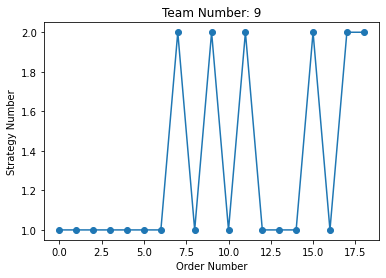

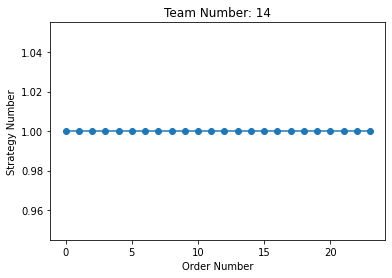

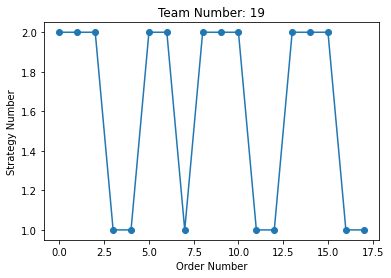

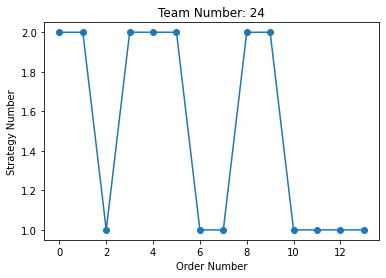

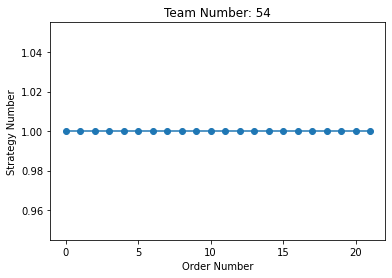

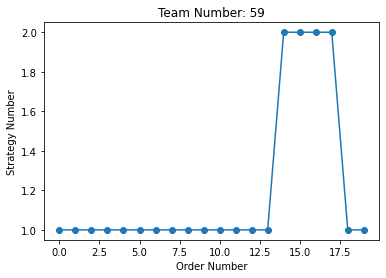

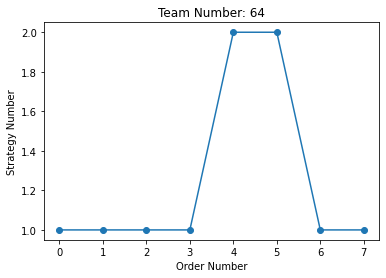

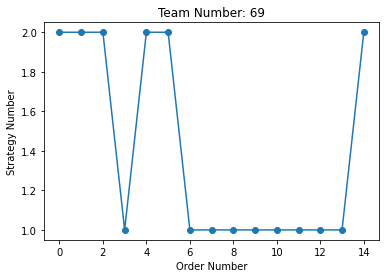

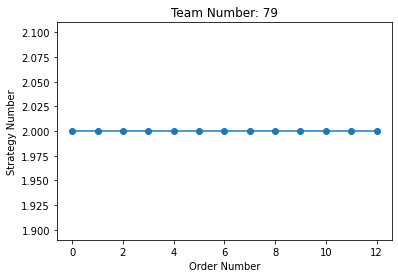

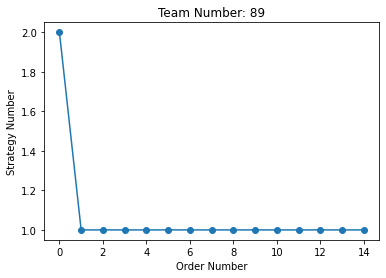

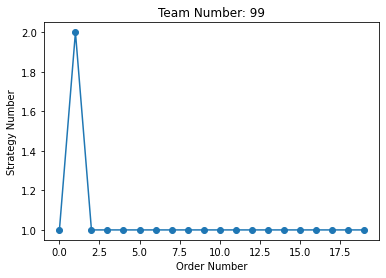

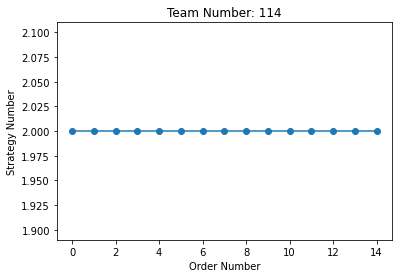

In [18]:
team_order_strats_dict = {}

for team_num in team_order_features_dict:
    orders_features_dict = team_order_features_dict[team_num]
    team_strat_data = get_naive_strategy_from_order_features(orders_features_dict)
    
    team_order_strats_dict[team_num] = team_strat_data
    
    team_order_features_dict[team_num]['strategy_of_order'] = team_strat_data
    plt.scatter(range(len(team_strat_data)), team_strat_data)
    plt.plot(range(len(team_strat_data)), team_strat_data)
    plt.title('Team Number: '+str(team_num))
    plt.ylabel("Strategy Number")
    plt.xlabel("Order Number")
    plt.show()


# Are these strategy features a good predictor of order speed? Are these features a good predictor of overall score?


## Use Simple Linear Model (Regression)



In [19]:
## Generate dataset
# X = order features
# Y = order rate
X_data_dict = {}
Y_data = []
for team_num in team_order_features_dict:
    team_data = team_order_features_dict[team_num]
    for feature_key in team_data:
        if feature_key == 'other_pot_states':
            continue
        if feature_key == 'order_completion_times':
            Y_data.extend(team_data[feature_key])
        else:
            if feature_key not in X_data_dict:
                X_data_dict[feature_key] = []
            X_data_dict[feature_key].extend(team_data[feature_key])

X_data = []
for feature_key in X_data_dict:
    X_data.append(X_data_dict[feature_key])
X_data = np.array(X_data).T
Y_data = np.array(Y_data)

print(X_data.shape)
print(Y_data.shape)

(203, 4)
(203,)


In [20]:
reg = LinearRegression().fit(X_data, Y_data)
score = reg.score(X_data, Y_data)
print('Score', score)
print('coefficients', reg.coef_)
print('intercept', reg.intercept_)



Score 0.14333453563223908
coefficients [ 0.50344509  0.39093144  0.33588403 -1.1729375 ]
intercept 3.9519632330573113


In [21]:
## Generate dataset
# X = team features
# Y = team score

## Generate dataset
# X = order features
# Y = order rate
X_data = []
Y_data = []
for team_num in team_order_features_dict:
    team_data = team_order_features_dict[team_num]
    team_add = []
    for feature_key in team_data:
        if feature_key == 'other_pot_states':
            continue
        else:
#             print('feature_key', feature_key)
            lst = team_data[feature_key]
            feature_mode = max(set(lst), key=lst.count)
            feature_mean = np.mean(lst)
            team_add.append(feature_mode)
            team_add.append(feature_mean)
    X_data.append(team_add)
    Y_data.append(team_num_to_score[team_num])

X_data = np.array(X_data)
Y_data = np.array(Y_data)

print(X_data.shape)
print(Y_data.shape)

(12, 10)
(12,)


In [22]:
reg = LinearRegression().fit(X_data, Y_data)
score = reg.score(X_data, Y_data)
print('Score', score)
print('coefficients', reg.coef_)
print('intercept', reg.intercept_)



Score 0.9428302351955382
coefficients [  -0.60308864   77.47323015  -13.62726622   21.96571867   16.44461595
   11.16240483    2.51026778  -13.55298831   67.08172843 -101.89367941]
intercept -198.40818248855857


# Implement Hidden Markov Model

## Forward Backward Algorithm 
## Baum Welch Algorithm


In [23]:

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        num_states = self.L
        num_obs = self.D
        

        # y = OBSERVATIONS (D) BY x = STATES (L)

        # Set start state transitions to be A_start.
        probs[0] = self.A_start
        for t in range(1, M+1):
            for o_curr in range(num_states):
                # For first state after the state state, only multiply the previous
                # probability by emission probability.
                if t == 1:
                    checkVal = np.array(probs[t-1]) * self.O[o_curr][x[t-1]]
                    # Set the maximum probability to be the value at the next probs[i, j] and 
                    # add the max probability sequence to seqs.
                    probs[t][o_curr] = max(checkVal)
                    add = []
                    for j in range(num_states):
                        add.append(str(j))
                    seqs[t] = add

                else:
                    # For other states, multiply the previous
                    # max probability by the emission and transition probability.
                    checkVal = np.multiply(probs[t-1], np.transpose(self.A)[o_curr]) * self.O[o_curr][x[t-1]]
                    max_index = np.argmax(checkVal)
                    # Set the maximum probability to be the value at the next probs[i, j] and 
                    # add the max probability sequence to seqs.
                    probs[t][o_curr] = max(checkVal)
                    add = seqs[t-1][max_index] + str(o_curr)
                    seqs[t][o_curr] = add

        # Get the maximum probability and max probability sequence. 
        max_prob_i = np.argmax(probs[M])
        max_seq = seqs[M][max_prob_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        num_states = self.L
        num_obs = self.D
        alphas[0] = self.A_start

        for t in range(1, M+1):
            for o_curr in range(num_states):
                # For each state, multiply the previous
                # max probability by the emission and transition probability, set alphas
                # to be the sum of probabilities.
                if t == 1:
                    checkVal = np.array(alphas[t-1]) * self.O[o_curr][x[t-1]] * self.A_start[0]
                    alphas[t][o_curr] = sum(checkVal)

                else:
                    checkVal = np.multiply(alphas[t-1], np.transpose(self.A)[o_curr]) * self.O[o_curr][x[t-1]]
                    max_index = np.argmax(checkVal)
                    alphas[t][o_curr] = sum(checkVal)

        return alphas



    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        num_states = self.L
        num_obs = self.D

        # Initialize end probabilities to be 1. 
        for i in range(num_states):
            betas[M][i] = 1

        t = M-1

        while t >= 0:
            for o_curr in range(num_states):
                # Take the sum of the previous probability times the 
                # transition and emission probabilities.
                checkVal = 0
                for i in range(len(self.A)):
                    checkVal += (betas[t+1][i]* self.A[o_curr][i]) * self.O[i][x[t]]   
                betas[t][o_curr] = checkVal
            t -= 1

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        N = len(X)

        for a in range(len(self.A)):
            for b in range(len(self.A[0])):
                sum2_num = 0
                sum2_denom = 0
                for i in range(N):
                    sum1_num = 0
                    sum1_denom = 0
                    # Compute each marginal probability.
                    for j in range(1, len(Y[i])):
                        if Y[i][j-1] == a:
                            sum1_denom += 1
                        if Y[i][j-1] == a and Y[i][j] == b:
                            sum1_num += 1
                    sum2_num += sum1_num
                    sum2_denom += sum1_denom

                if sum2_denom == 0:
                    self.A[a][b] = 0
                else:
                    self.A[a][b] = sum2_num/sum2_denom


        # Calculate each element of O using the M-step formulas.
        for w in range(len(self.O[0])):
            for a in range(len(self.O)):
                sum2_numerator = 0
                sum2_denom = 0
                for i in range(0, N):
                    sum1_numerator = 0
                    sum1_denom = 0
                    # Compute each marginal probability.
                    for j in range(len(Y[i])):
                        if Y[i][j] == a:
                            sum1_denom += 1
                            if X[i][j] == w:
                                sum1_numerator += 1
                    sum2_numerator += sum1_numerator
                    sum2_denom += sum1_denom
                if sum2_denom == 0:
                    self.O[a][w] = 0
                else:
                    self.O[a][w] = sum2_numerator/sum2_denom

    # Compute the marginal probabilities for the numerator of O,
    # and denominators of O and A. 
    def P_with_1Y(self, j, a, b, alphas, betas):
        numerator = alphas[j][a] * betas[j][a]
        summation = 0
        for p in range(self.L):
            summation += alphas[j][p] * betas[j][p]
        if summation == 0:
            return 0
        return numerator/summation


    # Compute the marginal probability for the numerator of A. 
    def P_with_2Y(self, x, j, a, b, alphas, betas):

        intermediate = 0
        for x_idx in range(len(x)):
            intermediate += self.O[b][x[x_idx]]
            
        numerator = alphas[j][a] * self.O[b][x[j]] * self.A[a][b] * betas[j+1][b]
        
        summation = 0
        for a_idx in range(self.L):
            for b_idx in range(self.L):
                summation += alphas[j][a_idx] * self.O[b_idx][x[j]] * self.A[a_idx][b_idx] * betas[j+1][b_idx]

        if summation == 0:
            return 0
        
        return numerator / summation

    def unsupervised_learning(self, X, N_iters=1000):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''
        #N = len(X)
        #print("shape of X", len(X), len(X[0]))

        for n_iter in range(N_iters):
            
            # Make temporary arrays to hold A and O values. 
            A_num = np.zeros((len(self.A), len(self.A[0])))
            A_den = np.zeros((len(self.A), len(self.A[0])))
            O_num = np.zeros((len(self.O), len(self.O[0])))
            O_den = np.zeros((len(self.O), len(self.O[0])))
            
            for x in X:
                # Compute alphas and betas. 
                alphas = self.forward(x)
                betas = self.backward(x)

                M = len(x)

                # Compute A denominator values first.
                for j in range(1, M+1):
                    for a in range(len(self.A)):
                        for b in range(len(self.A[0])):
                            A_den[a][b] += self.P_with_1Y(j, a, b, alphas, betas)

                # Compute O numerator and denominator values next.
                for j in range(1, M):
                    for w in range(len(self.O[0])):
                        for a in range(len(self.O)):
                            O_den[a][w] +=self.P_with_1Y(j, a, b, alphas, betas)
                            if x[j-1] == w:
                                O_num[a][w] += self.P_with_1Y(j, a, b, alphas, betas)
                        
                # Compute A numerator values next.
                for j in range(1, M-1):
                    for a in range(len(self.A)):
                        for b in range(len(self.A[0])):
                            A_num[a][b] += self.P_with_2Y(x, j, a, b, alphas, betas)
            
            # Set new A and O matrix values by dividing numerator over denominator values.
            for a in range(len(self.A)):
                for b in range(len(self.A[0])):
                    if A_den[a][b] == 0:
                        self.A[a][b] = 0
                    else:
                        self.A[a][b] = A_num[a][b]/A_den[a][b]

                    
            for w in range(len(self.O[0])):
                for a in range(len(self.O)):
                    if O_den[a][w] == 0:
                        self.O[a][w] = 0
                    else:
                        self.O[a][w] = O_num[a][w]/O_den[a][w]


        


    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        states = []
        # Randomly select a state state.
        current_state = np.random.randint(len(self.A))

        # For an emission of length M
        for m in range(M):
            current_A = self.A[current_state]
            rand_prob_A = np.random.uniform(0, 1)

            next_state = 0
            # Find the next state by randomly picking a 
            # probability between 0 and 1. If this 
            # probability falls in the range for a particular state,
            # assign that state to be the next state.
            for a1 in range(len(current_A)):
                sum_A = 0
                for a2 in range(a1):
                    sum_A += current_A[a2]
                if sum_A > rand_prob_A:
                    break
                next_state = a1
            current_state = next_state

            # Find the next observation emission by randomly picking a 
            # probability between 0 and 1. If this 
            # probability falls in the range for a particular emission for 
            # the current state,
            # assign that emission to be the emission.
            next_emission = 0
            current_O = self.O[current_state]
            rand_prob_O = np.random.uniform(0, 1)
            for o1 in range(len(current_O)):
                sum_O = 0
                for o2 in range(o1):
                    sum_O += current_O[o2]
                if sum_O > rand_prob_O:
                    break
                next_emission = o1

            # Add the new state and new emission to the lists. 

            states.append(current_state)
            emission.append(next_emission)


        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob



In [24]:

def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


In [25]:

def unsupervised_HMM(X, n_states, N_iters):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm


    # random.seed(420)
    # A = [[random.random() for i in range(L)] for j in range(L)]

    # # Randomly initialize and normalize matrix O.
    # random.seed(69)
    # O = [[random.random() for i in range(D)] for j in range(L)]

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

## HMM Helper Functions

In [26]:
def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


# Generate Hidden Markov Model Data

In [27]:
team_order_features_dict

{9: {'other_pot_contains_num_onions': [3,
   0,
   3,
   0,
   3,
   0,
   3,
   1,
   3,
   1,
   3,
   1,
   3,
   0,
   3,
   1,
   3,
   1,
   0],
  'other_pot_states': ['ready',
   'empty',
   'ready',
   'empty',
   'ready',
   'empty',
   'ready',
   'idle',
   'ready',
   'idle',
   'cooking',
   'idle',
   'cooking',
   'empty',
   'cooking',
   'idle',
   'cooking',
   'idle',
   'empty'],
  'steps_p1_took_total_order': [9,
   10,
   10,
   9,
   9,
   9,
   9,
   9,
   9,
   9,
   9,
   9,
   13,
   9,
   9,
   9,
   9,
   9,
   15],
  'steps_p2_took_total_order': [9,
   10,
   9,
   9,
   12,
   9,
   9,
   9,
   10,
   11,
   11,
   9,
   12,
   9,
   9,
   13,
   9,
   9,
   9],
  'order_completion_times': [6.748999999999999,
   14.699000000000002,
   10.651,
   7.950000000000003,
   12.446999999999996,
   10.497,
   6.150000000000006,
   15.150000000000006,
   12.298999999999992,
   11.099999999999994,
   10.799999999999997,
   13.495999999999995,
   9.0,
   10.349999999

In [28]:
## Generate dataset
# X = team features
# Y = team score

## Generate dataset
# X = order features
# Y = order rate
observation_data = []
hidden_state_data = []

team_numbers = []

for team_num in team_order_features_dict:
    team_numbers.append(team_num)
    team_data = team_order_features_dict[team_num]
    
    # observation = order duration 
    order_competion_time = team_data['order_completion_times']
    n_onions_other_pot = team_data['other_pot_contains_num_onions']
    
    hidden = team_data['strategy_of_order']
    
    observation = []
    hidden_add = []
    for j in range(5):
        observation.append(n_onions_other_pot[j])
        hidden_add.append(hidden[j])
    
    observation_data.append(observation)
    hidden_state_data.append(hidden_add)


observation_data = np.array(observation_data)
hidden_state_data = hidden_state_data

# print(observation_data.shape)
# print(hidden_state_data.shape)

# Use HMM Model

## Unsupervised Learning

In [29]:

X = observation_data
# Y = hidden_state_data

n_states = 2
N_iters = 100

test_unsuper_hmm = unsupervised_HMM(X, n_states, N_iters)

print('emission', test_unsuper_hmm.generate_emission(10))

emission ([3, 0, 3, 3, 0, 3, 0, 3, 2, 3], [1, 0, 1, 1, 0, 1, 0, 1, 0, 1])


In [30]:
for j in range(len(X)):
    print('viterbi: hidden seq: Team '+str(team_numbers[j])+": ", test_unsuper_hmm.viterbi(X[j]))

viterbi: hidden seq: Team 9:  10101
viterbi: hidden seq: Team 14:  10101
viterbi: hidden seq: Team 19:  01010
viterbi: hidden seq: Team 24:  10101
viterbi: hidden seq: Team 54:  10101
viterbi: hidden seq: Team 59:  10101
viterbi: hidden seq: Team 64:  10101
viterbi: hidden seq: Team 69:  01010
viterbi: hidden seq: Team 79:  01010
viterbi: hidden seq: Team 89:  01010
viterbi: hidden seq: Team 99:  10101
viterbi: hidden seq: Team 114:  01010


In [31]:
X

array([[3, 0, 3, 0, 3],
       [3, 0, 3, 0, 3],
       [1, 2, 2, 3, 0],
       [2, 2, 3, 2, 2],
       [3, 0, 3, 0, 3],
       [3, 0, 3, 0, 3],
       [3, 0, 3, 0, 2],
       [0, 0, 1, 3, 1],
       [0, 1, 0, 0, 0],
       [0, 3, 0, 3, 0],
       [3, 1, 3, 0, 3],
       [0, 0, 0, 0, 0]])

## Supervised HMM Learning

In [32]:
# X = np.array([[0,1,0], [1,1,1], [0,0,1]])

# Y = np.array([[3,1,0], [1,2,1], [1,0,1]])

X = observation_data
Y = hidden_state_data

n_states = 2
N_iters = 100

test_super_hmm = supervised_HMM(X, Y)

print('emission', test_super_hmm.generate_emission(10))

emission ([3, 0, 0, 3, 3, 3, 3, 3, 0, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [33]:
for j in range(len(X)):
    print('viterbi: hidden seq: Team '+str(team_numbers[j])+": ", test_super_hmm.viterbi(X[j]))
    

viterbi: hidden seq: Team 9:  11111
viterbi: hidden seq: Team 14:  11111
viterbi: hidden seq: Team 19:  00000
viterbi: hidden seq: Team 24:  00000
viterbi: hidden seq: Team 54:  11111
viterbi: hidden seq: Team 59:  11111
viterbi: hidden seq: Team 64:  00000
viterbi: hidden seq: Team 69:  00000
viterbi: hidden seq: Team 79:  00000
viterbi: hidden seq: Team 89:  11111
viterbi: hidden seq: Team 99:  00000
viterbi: hidden seq: Team 114:  11111


# Chunk Up the Data Into Actions